<div style="font-size:22px; margin-top:20px; margin-bottom:15px">
<h2>EGARCH Model for Volatility Dynamics in Digital Asset Markets</h2>
</div>

<div style="font-size:18px; line-height:1.6">

The **Exponential Generalized Autoregressive Conditional Heteroskedasticity (EGARCH)** model is a nonlinear stochastic volatility model proposed by Nelson (1991).  
It belongs to the **GARCH family**, but unlike the standard GARCH specification, it models the **logarithm of the conditional variance**, ensuring positivity without imposing explicit parameter constraints.

In the context of **crypto-asset markets**, where volatility clustering and asymmetric responses to shocks are prominent, EGARCH captures the **leverage effect** — the empirical observation that negative returns tend to increase future volatility more than positive ones of equal magnitude.

</div>

---

<div style="font-size:22px; margin-top:15px">
Mathematical Specification
</div>

<div style="font-size:20px; margin-top:10px; margin-bottom:10px">
The EGARCH(p, o, q) model can be expressed as:
</div>

<div style="font-size:22px; margin-top:15px">
$$
\begin{aligned}
r_t &= \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim i.i.d.(0,1) \\\\
\ln(\sigma_t^2) &= \omega 
+ \sum_{i=1}^{p} \beta_i \ln(\sigma_{t-i}^2)
+ \sum_{j=1}^{q} \alpha_j \left( |z_{t-j}| - \mathbb{E}|z_{t-j}| \right)
+ \sum_{k=1}^{o} \gamma_k z_{t-k}
\end{aligned}
$$
</div>

<div style="font-size:18px; margin-top:10px; line-height:1.6">

**Where:**

<div style="font-size:18px; line-height:1.6; margin-top:10px">

<div style="font-size:18px; line-height:1.6; margin-top:10px">

\\[
\begin{array}{ll}
r_t &\text{: Asset return at time } t \; (\text{e.g. log-return of ETH/USDT}) \\\\
\mu &\text{: Unconditional mean of returns} \\\\
\sigma_t^2 &\text{: Conditional variance of the innovation term } \epsilon_t \\\\
z_t &\text{: Standardized residuals, typically } i.i.d.(0,1) \text{ with zero mean and unit variance} \\\\
\omega &\text{: Constant term controlling the long-run volatility level} \\\\
\beta_i &\text{: Autoregressive coefficients describing the persistence of past volatility} \\\\
\alpha_j &\text{: Coefficients capturing the magnitude effect (response to absolute shocks)} \\\\
\gamma_k &\text{: Coefficients representing asymmetry (leverage effect), allowing negative shocks to have stronger impacts on volatility}
\end{array}
\\]
</div>

---

<div style="font-size:22px; margin-top:20px">
EGARCH in the Context of Digital Assets
</div>

<div style="font-size:18px; line-height:1.6; margin-top:10px">

The **EGARCH model** is particularly suited for **digital asset volatility modeling**, as cryptocurrencies exhibit:
- **High-frequency volatility clustering**, driven by microstructure noise and continuous trading.  
- **Strong asymmetry** in volatility response due to speculative deleveraging and liquidation cascades.  
- **Non-stationary periods** with volatility bursts during market stress events (e.g. exchange hacks, regulatory news).

By applying EGARCH to high-resolution OHLCV data (e.g. 5-minute ETH candles), we estimate the **conditional volatility process** that underlies return dynamics.  
This allows for better **risk forecasting**, **VaR estimation**, and **dynamic position sizing** within a quantitative trading or risk management framework.

</div>

---

<div style="font-size:22px; margin-top:20px">
Interpretation of Parameters
</div>

<div style="font-size:18px; line-height:1.6; margin-top:10px">

\\[
\begin{array}{ll}
\text{Large } \beta_i &\text{: High volatility persistence (slow mean reversion)} \\\\
\text{Large } \alpha_j &\text{: Strong reaction to recent shocks (volatility-of-volatility)} \\\\
\text{Negative } \gamma_k &\text{: Leverage effect — volatility rises more after negative returns} \\\\
\text{Constant } \omega &\text{: Determines the long-run equilibrium level of log-variance}
\end{array}
\\]

</div>

<div style="font-size:18px; line-height:1.6; margin-top:15px">

When fitted on crypto returns, the EGARCH model captures the **stylized facts** of digital markets:  
fat-tailed return distributions, volatility clustering, and asymmetric feedback loops between returns and conditional variance.

</div>
---

<div style="font-size:18px; margin-top:15px; margin-bottom:25px">
In this notebook, we implement and estimate the EGARCH(1,1,1) model for Ethereum intraday returns, visualize conditional volatility, and compare it against realized volatility measures derived from rolling standard deviations of log-returns.
</div>


In [1]:
import os, sys

# --- Project path setup ---
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.config import *
from src.data_loader import load_eth_data
from src.egarch_model import train_egarch, plot_conditional_variance


[config] Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
[config] Data path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
[config] Plots directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\plots
[config] Logs directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\logs
[config] Default EGARCH params -> p=1, o=1, q=1, dist=t


📂 Loading data from: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
✅ Data loaded successfully
Shape: (17280, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base', 'taker_buy_quote', 'volume_log', 'volume_log_z']

            open_time     open     high      low    close     volume  \
0 2024-01-01 00:00:00  2281.87  2287.84  2281.27  2287.84   910.5701   
1 2024-01-01 00:05:00  2287.83  2291.83  2287.06  2290.77  1652.9290   
2 2024-01-01 00:10:00  2290.77  2296.97  2290.76  2296.71  1829.5259   
3 2024-01-01 00:15:00  2296.71  2297.00  2292.36  2292.36   890.8524   
4 2024-01-01 00:20:00  2292.37  2295.87  2292.30  2294.67   763.7046   

   quote_asset_volume  num_trades  taker_buy_base  taker_buy_quote  \
0        2.080313e+06        2593        585.7254     1.338369e+06   
1        3.785227e+06        3354       1058.4951     2.423910e+06   
2        4.197682e+06        3321


Remove NaN values and continue? (y/n):  y


🧹 Dropping NaN rows and continuing...

════════════════════════════════════════════════════════════
                    Model Input Summary                     
════════════════════════════════════════════════════════════
 Observations :      17180
 Mean          :   0.000022
 Std Dev       :   0.001707
 Kurtosis      :        nan

════════════════════════════════════════════════════════════
                 Initializing EGARCH Model                  
════════════════════════════════════════════════════════════

════════════════════════════════════════════════════════════
                   Training EGARCH Model                    
════════════════════════════════════════════════════════════


C:\Users\edgen\anaconda3\envs\PythonforDataScience\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02926. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



════════════════════════════════════════════════════════════
                   Model Training Summary                   
════════════════════════════════════════════════════════════
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                10708.1
Distribution:      Standardized Student's t   AIC:                          -21404.1
Method:                  Maximum Likelihood   BIC:                          -21357.6
                                              No. Observations:                17180
Date:                      Mon, Oct 13 2025   Df Residuals:                    17179
Time:                              09:27:21   Df Model:                            1
                                  Mean Model       

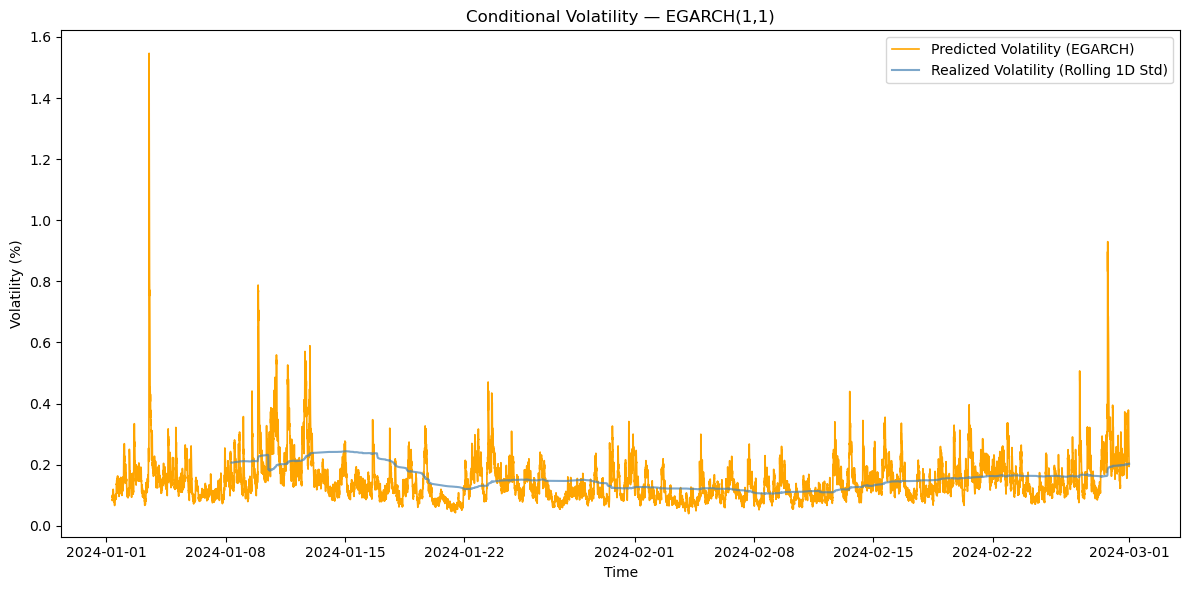

In [2]:
# === Load and prepare data ===
df = load_eth_data()

# === Train EGARCH model ===
res, df = train_egarch(df, p=1, o=1, q=1)

# === Plot results ===
plot_conditional_variance(res, df, save_path=os.path.join(PLOTS_DIR, "egarch_notebook_output.png"))
